In [2]:
!pip install ipywidgets==7.6.0

In [41]:
!pip install -r src/requirements.txt

## Dataset

In [4]:
from datasets import load_dataset
cola_dataset = load_dataset("glue", "cola")

In [5]:
cola_dataset

DatasetDict({
    train: Dataset({
        features: ['sentence', 'label', 'idx'],
        num_rows: 8551
    })
    validation: Dataset({
        features: ['sentence', 'label', 'idx'],
        num_rows: 1043
    })
    test: Dataset({
        features: ['sentence', 'label', 'idx'],
        num_rows: 1063
    })
})

In [6]:
import sagemaker
import boto3

sess = sagemaker.Session()
bucket = sess.default_bucket()

print(bucket, boto3.Session())

sagemaker-us-east-1-046017406246 Session(region_name='us-east-1')


In [7]:
cola_dataset.save_to_disk("./dataset")

Saving the dataset (0/1 shards):   0%|          | 0/8551 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1043 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1063 [00:00<?, ? examples/s]

## Upload data to S3

In [8]:
prefix = "project-3-udacity/dataset"
upload_data = sess.upload_data(path='dataset', key_prefix=prefix)

## Explore data

In [8]:
train = cola_dataset["train"]
valid = cola_dataset["validation"]
test = cola_dataset["test"]
len(train), len(valid), len(test)

(8551, 1043, 1063)

In [9]:
train[0]

{'sentence': "Our friends won't buy this analysis, let alone the next one we propose.",
 'label': 1,
 'idx': 0}

In [10]:
valid[0], test[0]

({'sentence': 'The sailors rode the breeze clear of the rocks.',
  'label': 1,
  'idx': 0},
 {'sentence': 'Bill whistled past the house.', 'label': -1, 'idx': 0})

#### Label 1: grammatically correct. 
#### Label 0: grammatically incorrect.

In [11]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

In [12]:
tokenizer

Using bos_token, but it is not set yet.
Using eos_token, but it is not set yet.


DistilBertTokenizerFast(name_or_path='distilbert-base-uncased', vocab_size=30522, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True),  added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	100: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	101: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	102: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	103: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}

In [13]:
num = 15
train[num]['sentence']

'Bill broke the bathtub into pieces.'

In [14]:
tokenizer(train[num]['sentence'])

{'input_ids': [101, 3021, 3631, 1996, 7198, 28251, 2046, 4109, 1012, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [15]:
tokenizer.decode(tokenizer(train[num]['sentence'])['input_ids'])

'[CLS] bill broke the bathtub into pieces. [SEP]'

## Hyperparameter tuning

In [16]:
from datetime import datetime
import os

from sagemaker.pytorch import PyTorch
from sagemaker import get_execution_role

from sagemaker.tuner import (
    CategoricalParameter,
    ContinuousParameter,
    HyperparameterTuner,
)

In [17]:
sess = sagemaker.Session()
bucket = sess.default_bucket()
prefix = "project-3-udacity"
role = get_execution_role()
print(bucket, role)

sagemaker-us-east-1-046017406246 arn:aws:iam::046017406246:role/service-role/AmazonSageMaker-ExecutionRole-20230221T001832


In [18]:
hyperparameter_ranges = {
    "lr": ContinuousParameter(2e-5, 2e-4),
    "batch-size": CategoricalParameter([32, 64]),
    "max-length": CategoricalParameter([128, 256])
}

In [19]:
objective_metric_name = "Average Validation Loss"
objective_type = "Minimize"
metric_definitions = [{"Name": "Average Validation Loss", "Regex": "Validation set: Average loss: ([0-9\\.]+)"}]

In [31]:
dataset_path = f"s3://{bucket}/{prefix}/dataset"
print(dataset_path)

os.environ["SM_CHANNEL_TRAINING"] = dataset_path

s3://sagemaker-us-east-1-046017406246/project-3-udacity/dataset


In [35]:
estimator = PyTorch(
    entry_point="hpo.py",
    source_dir="./src",
    output_path=f"s3://{bucket}/{prefix}",
    base_job_name="hyperparameter-tuning-cola",
    role=role,
    instance_count=1,
    instance_type="ml.g4dn.xlarge",
    framework_version="1.10",
    py_version="py38"
)

In [36]:
tuner = HyperparameterTuner(
    estimator,
    objective_metric_name,
    hyperparameter_ranges,
    metric_definitions,
    max_jobs=2,
    max_parallel_jobs=2,
    objective_type=objective_type,
)

In [37]:
tuner.fit(inputs={
        "training": os.environ["SM_CHANNEL_TRAINING"], 
    },
    wait=True
)

................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................!


In [38]:
tuner.best_training_job()

'pytorch-training-231007-2155-002-2d8f0a64'

In [39]:
tuner.best_estimator().hyperparameters()


2023-10-07 22:32:28 Starting - Preparing the instances for training
2023-10-07 22:32:28 Downloading - Downloading input data
2023-10-07 22:32:28 Training - Training image download completed. Training in progress.
2023-10-07 22:32:28 Uploading - Uploading generated training model
2023-10-07 22:32:28 Completed - Resource released due to keep alive period expiry


{'_tuning_objective_metric': '"Average Validation Loss"',
 'batch-size': '"32"',
 'lr': '5.850103780841257e-05',
 'max-length': '"256"',
 'sagemaker_container_log_level': '20',
 'sagemaker_estimator_class_name': '"PyTorch"',
 'sagemaker_estimator_module': '"sagemaker.pytorch.estimator"',
 'sagemaker_job_name': '"hyperparameter-tuning-cola-2023-10-07-21-55-53-870"',
 'sagemaker_program': '"hpo.py"',
 'sagemaker_region': '"us-east-1"',
 'sagemaker_submit_directory': '"s3://sagemaker-us-east-1-046017406246/hyperparameter-tuning-cola-2023-10-07-21-55-53-870/source/sourcedir.tar.gz"'}

In [53]:
max_length = int(tuner.best_estimator().hyperparameters()['max-length'].replace('"', ''))
lr = float(tuner.best_estimator().hyperparameters()['lr'])
batch_size = int(tuner.best_estimator().hyperparameters()['batch-size'].replace('"', ''))


2023-10-07 22:32:28 Starting - Preparing the instances for training
2023-10-07 22:32:28 Downloading - Downloading input data
2023-10-07 22:32:28 Training - Training image download completed. Training in progress.
2023-10-07 22:32:28 Uploading - Uploading generated training model
2023-10-07 22:32:28 Completed - Resource released due to keep alive period expiry

2023-10-07 22:32:28 Starting - Preparing the instances for training
2023-10-07 22:32:28 Downloading - Downloading input data
2023-10-07 22:32:28 Training - Training image download completed. Training in progress.
2023-10-07 22:32:28 Uploading - Uploading generated training model
2023-10-07 22:32:28 Completed - Resource released due to keep alive period expiry

2023-10-07 22:32:28 Starting - Preparing the instances for training
2023-10-07 22:32:28 Downloading - Downloading input data
2023-10-07 22:32:28 Training - Training image download completed. Training in progress.
2023-10-07 22:32:28 Uploading - Uploading generated training

In [54]:
max_length, lr, batch_size

(256, 5.850103780841257e-05, 32)

## Model Profiling and Debugging

In [69]:
from sagemaker.debugger import (
    Rule,
    DebuggerHookConfig,
    ProfilerRule,
    ProfilerConfig, 
    FrameworkProfile,
    rule_configs,
    CollectionConfig
)

import smdebug.pytorch as smd
from smdebug.trials import create_trial
from smdebug.core.modes import ModeKeys
from smdebug.profiler.analysis.notebook_utils.training_job import TrainingJob
from smdebug.profiler.analysis.notebook_utils.timeline_charts import TimelineCharts

In [81]:
rules = [
    Rule.sagemaker(rule_configs.loss_not_decreasing()),
    ProfilerRule.sagemaker(rule_configs.LowGPUUtilization()),
    ProfilerRule.sagemaker(rule_configs.ProfilerReport()),
    Rule.sagemaker(rule_configs.vanishing_gradient()),
    Rule.sagemaker(rule_configs.overfit()),
    Rule.sagemaker(rule_configs.overtraining()),
    Rule.sagemaker(rule_configs.poor_weight_initialization()),
]

profiler_config = ProfilerConfig(
    system_monitor_interval_millis=500, framework_profile_params=FrameworkProfile(num_steps=10)
)

collection_config_list = [
    CollectionConfig(
        name="CrossEntropyLoss_output_0",
        parameters={
            "include_regex": "CrossEntropyLoss_output_0", 
            "train.save_interval": "20",
            "eval.save_interval": "4"
        }
    )
]

debugger_config = DebuggerHookConfig(
    hook_parameters={"train.save_interval": "100", "eval.save_interval": "10"},
    collection_configs=collection_config_list
)

hyperparameters = {"epochs": 5, "batch-size": batch_size, "lr": lr, "max-length": max_length}

In [82]:
estimator = PyTorch(
    entry_point="train_model.py",
    source_dir="./src",
    output_path=f"s3://{bucket}/{prefix}",
    base_job_name="cola-distilbert-model",
    role=role,
    instance_count=1,
    instance_type="ml.g4dn.xlarge",
    hyperparameters=hyperparameters,
    framework_version="1.10",
    py_version="py38",
    rules=rules,
    profiler_config=profiler_config,
    debugger_hook_config=debugger_config
)

In [83]:
estimator.fit(inputs={
        "training": os.environ["SM_CHANNEL_TRAINING"], 
    },
    wait=True
)

INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: latest.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: latest.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: latest.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: latest.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: latest.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: latest.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker.i

2023-10-08 00:07:59 Starting - Starting the training job...
2023-10-08 00:08:26 Starting - Preparing the instances for trainingLossNotDecreasing: InProgress
VanishingGradient: InProgress
Overfit: InProgress
Overtraining: InProgress
PoorWeightInitialization: InProgress
LowGPUUtilization: InProgress
ProfilerReport: InProgress
......
2023-10-08 00:09:26 Downloading - Downloading input data...
2023-10-08 00:09:57 Training - Downloading the training image.....................
2023-10-08 00:13:27 Training - Training image download completed. Training in progress...bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2023-10-08 00:13:34,910 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2023-10-08 00:13:34,936 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2023-10-08 00:13:34,940 sagemaker_pytorch_container.training INFO     Invoking user training sc

In [85]:
session = boto3.session.Session()
region = session.region_name

training_job_name = estimator.latest_training_job.name
print(f"Training jobname: {training_job_name}")
print(f"Region: {region}")

trial = create_trial(estimator.latest_job_debugger_artifacts_path())

print(trial.tensor_names())
print("Train: ", len(trial.tensor("CrossEntropyLoss_output_0").steps(mode=ModeKeys.TRAIN)))
print("Valid: ", len(trial.tensor("CrossEntropyLoss_output_0").steps(mode=ModeKeys.EVAL)))

Training jobname: cola-distilbert-model-2023-10-08-00-07-59-269
Region: us-east-1
[2023-10-08 03:50:07.163 pytorch-1-10-gpu-py-ml-g4dn-xlarge-53638dc8bb3d40f5ed7ac21aaf03:222 INFO s3_trial.py:42] Loading trial debug-output at path s3://sagemaker-us-east-1-046017406246/project-3-udacity/cola-distilbert-model-2023-10-08-00-07-59-269/debug-output
[2023-10-08 03:50:09.183 pytorch-1-10-gpu-py-ml-g4dn-xlarge-53638dc8bb3d40f5ed7ac21aaf03:222 INFO trial.py:197] Training has ended, will refresh one final time in 1 sec.
[2023-10-08 03:50:10.203 pytorch-1-10-gpu-py-ml-g4dn-xlarge-53638dc8bb3d40f5ed7ac21aaf03:222 INFO trial.py:210] Loaded all steps
['CrossEntropyLoss_output_0', 'gradient/DistilBertForSequenceClassification_classifier.bias', 'gradient/DistilBertForSequenceClassification_classifier.weight', 'gradient/DistilBertForSequenceClassification_distilbert.embeddings.LayerNorm.bias', 'gradient/DistilBertForSequenceClassification_distilbert.embeddings.LayerNorm.weight', 'gradient/DistilBertFor

In [89]:
tj = TrainingJob(training_job_name, region)
tj.wait_for_sys_profiling_data_to_be_available()

system_metrics_reader = tj.get_systems_metrics_reader()
system_metrics_reader.refresh_event_file_list()

view_timeline_charts = TimelineCharts(
    system_metrics_reader,
    framework_metrics_reader=None,
    select_dimensions=["CPU", "GPU"],
    select_events=["total"],
)

rule_output_path = os.path.join(estimator.output_path, estimator.latest_training_job.job_name, "rule-output")
print(f"You will find the profiler report in {rule_output_path}")

ProfilerConfig:{'S3OutputPath': 's3://sagemaker-us-east-1-046017406246/project-3-udacity', 'ProfilingIntervalInMilliseconds': 500, 'ProfilingParameters': {'DataloaderProfilingConfig': '{"StartStep": 0, "NumSteps": 10, "MetricsRegex": ".*", }', 'DetailedProfilingConfig': '{"StartStep": 0, "NumSteps": 10, }', 'FileOpenFailThreshold': '50', 'HorovodProfilingConfig': '{"StartStep": 0, "NumSteps": 10, }', 'LocalPath': '/opt/ml/output/profiler', 'PythonProfilingConfig': '{"StartStep": 0, "NumSteps": 10, "ProfilerName": "cprofile", "cProfileTimer": "total_time", }', 'RotateFileCloseIntervalInSeconds': '60', 'RotateMaxFileSizeInBytes': '10485760', 'SMDataParallelProfilingConfig': '{"StartStep": 0, "NumSteps": 10, }'}}
s3 path:s3://sagemaker-us-east-1-046017406246/project-3-udacity/cola-distilbert-model-2023-10-08-00-07-59-269/profiler-output


Profiler data from system is available
[2023-10-08 03:52:06.226 pytorch-1-10-gpu-py-ml-g4dn-xlarge-53638dc8bb3d40f5ed7ac21aaf03:222 INFO metrics_reader_

You will find the profiler report in s3://sagemaker-us-east-1-046017406246/project-3-udacity/cola-distilbert-model-2023-10-08-00-07-59-269/rule-output


In [91]:
! aws s3 ls {rule_output_path} --recursive

2023-10-08 00:30:01     382481 project-3-udacity/cola-distilbert-model-2023-10-08-00-07-59-269/rule-output/ProfilerReport/profiler-output/profiler-report.html
2023-10-08 00:30:01     231811 project-3-udacity/cola-distilbert-model-2023-10-08-00-07-59-269/rule-output/ProfilerReport/profiler-output/profiler-report.ipynb
2023-10-08 00:29:56        192 project-3-udacity/cola-distilbert-model-2023-10-08-00-07-59-269/rule-output/ProfilerReport/profiler-output/profiler-reports/BatchSize.json
2023-10-08 00:29:56       3211 project-3-udacity/cola-distilbert-model-2023-10-08-00-07-59-269/rule-output/ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json
2023-10-08 00:29:56       2058 project-3-udacity/cola-distilbert-model-2023-10-08-00-07-59-269/rule-output/ProfilerReport/profiler-output/profiler-reports/Dataloader.json
2023-10-08 00:29:56        325 project-3-udacity/cola-distilbert-model-2023-10-08-00-07-59-269/rule-output/ProfilerReport/profiler-output/profiler-reports/GPUMemoryIn

In [92]:
estimator.latest_training_job.rule_job_summary()

[{'RuleConfigurationName': 'LossNotDecreasing',
  'RuleEvaluationJobArn': 'arn:aws:sagemaker:us-east-1:046017406246:processing-job/cola-distilbert-model-2023-LossNotDecreasing-4805cee1',
  'RuleEvaluationStatus': 'NoIssuesFound',
  'LastModifiedTime': datetime.datetime(2023, 10, 8, 0, 30, 40, 860000, tzinfo=tzlocal())},
 {'RuleConfigurationName': 'VanishingGradient',
  'RuleEvaluationJobArn': 'arn:aws:sagemaker:us-east-1:046017406246:processing-job/cola-distilbert-model-2023-VanishingGradient-a7ecdef3',
  'RuleEvaluationStatus': 'NoIssuesFound',
  'LastModifiedTime': datetime.datetime(2023, 10, 8, 0, 30, 40, 860000, tzinfo=tzlocal())},
 {'RuleConfigurationName': 'Overfit',
  'RuleEvaluationJobArn': 'arn:aws:sagemaker:us-east-1:046017406246:processing-job/cola-distilbert-model-2023-Overfit-3bd9ef58',
  'RuleEvaluationStatus': 'IssuesFound',
  'StatusDetails': 'RuleEvaluationConditionMet: Evaluation of the rule Overfit at step 919 resulted in the condition being met\n',
  'LastModifiedTi

In [93]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import host_subplot

def get_data(trial, tname, mode):
    tensor = trial.tensor(tname)
    steps = tensor.steps(mode=mode)
    vals = []
    for s in steps:
        vals.append(tensor.value(s, mode=mode))
    return steps, vals

def plot_tensor(trial, tensor_name):

    steps_train, vals_train = get_data(trial, tensor_name, mode=ModeKeys.TRAIN)
    print("loaded TRAIN data")
    steps_eval, vals_eval = get_data(trial, tensor_name, mode=ModeKeys.EVAL)
    print("loaded EVAL data")

    fig = plt.figure(figsize=(10, 7))
    host = host_subplot(111)

    par = host.twiny()

    host.set_xlabel("Steps (TRAIN)")
    par.set_xlabel("Steps (EVAL)")
    host.set_ylabel(tensor_name)

    (p1,) = host.plot(steps_train, vals_train, label=tensor_name)
    print("completed TRAIN plot")
    (p2,) = par.plot(steps_eval, vals_eval, label="val_" + tensor_name)
    print("completed EVAL plot")
    leg = plt.legend()

    host.xaxis.get_label().set_color(p1.get_color())
    leg.texts[0].set_color(p1.get_color())

    par.xaxis.get_label().set_color(p2.get_color())
    leg.texts[1].set_color(p2.get_color())

    plt.ylabel(tensor_name)

    plt.show()

loaded TRAIN data
loaded EVAL data
completed TRAIN plot
completed EVAL plot


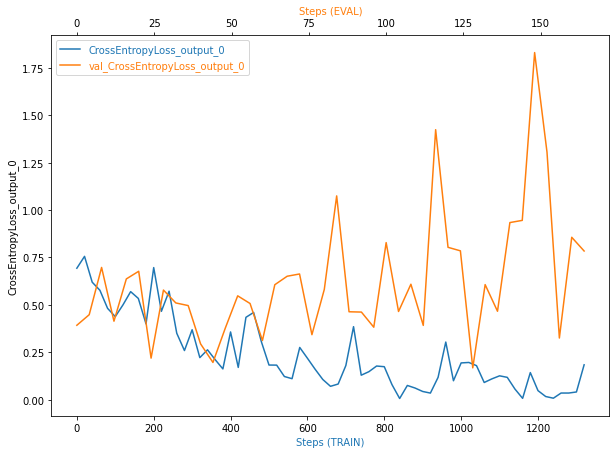

In [94]:
plot_tensor(trial, "CrossEntropyLoss_output_0")

In [99]:
! aws s3 cp {rule_output_path} ./ --recursive

download: s3://sagemaker-us-east-1-046017406246/project-3-udacity/cola-distilbert-model-2023-10-08-00-07-59-269/rule-output/ProfilerReport/profiler-output/profiler-reports/LowGPUUtilization.json to ProfilerReport/profiler-output/profiler-reports/LowGPUUtilization.json
download: s3://sagemaker-us-east-1-046017406246/project-3-udacity/cola-distilbert-model-2023-10-08-00-07-59-269/rule-output/ProfilerReport/profiler-output/profiler-reports/OverallFrameworkMetrics.json to ProfilerReport/profiler-output/profiler-reports/OverallFrameworkMetrics.json
download: s3://sagemaker-us-east-1-046017406246/project-3-udacity/cola-distilbert-model-2023-10-08-00-07-59-269/rule-output/ProfilerReport/profiler-output/profiler-reports/BatchSize.json to ProfilerReport/profiler-output/profiler-reports/BatchSize.json
download: s3://sagemaker-us-east-1-046017406246/project-3-udacity/cola-distilbert-model-2023-10-08-00-07-59-269/rule-output/ProfilerReport/profiler-output/profiler-reports/LoadBalancing.json to Pro

In [154]:
import IPython

# get the autogenerated folder name of profiler report
profiler_report_name = [
    rule["RuleConfigurationName"]
    for rule in estimator.latest_training_job.rule_job_summary()
    if "Profiler" in rule["RuleConfigurationName"]
][0]


IPython.display.HTML(filename=profiler_report_name + "/profiler-output/profiler-report.html")

## Model Deploying

In [104]:
!aws s3 cp "s3://sagemaker-us-east-1-046017406246/project-3-udacity/cola-distilbert-model-2023-10-08-00-07-59-269/output/model.tar.gz" .

download: s3://sagemaker-us-east-1-046017406246/project-3-udacity/cola-distilbert-model-2023-10-08-00-07-59-269/output/model.tar.gz to ./model.tar.gz


In [109]:
import tarfile

with tarfile.open("./model.tar.gz", 'r:gz') as tar:
    tar.extractall(path="./")

In [136]:
from src.net import Net
import torch

In [129]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [130]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [137]:
model = Net(device)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [140]:
model.state_dict().keys()

odict_keys(['model.distilbert.embeddings.word_embeddings.weight', 'model.distilbert.embeddings.position_embeddings.weight', 'model.distilbert.embeddings.LayerNorm.weight', 'model.distilbert.embeddings.LayerNorm.bias', 'model.distilbert.transformer.layer.0.attention.q_lin.weight', 'model.distilbert.transformer.layer.0.attention.q_lin.bias', 'model.distilbert.transformer.layer.0.attention.k_lin.weight', 'model.distilbert.transformer.layer.0.attention.k_lin.bias', 'model.distilbert.transformer.layer.0.attention.v_lin.weight', 'model.distilbert.transformer.layer.0.attention.v_lin.bias', 'model.distilbert.transformer.layer.0.attention.out_lin.weight', 'model.distilbert.transformer.layer.0.attention.out_lin.bias', 'model.distilbert.transformer.layer.0.sa_layer_norm.weight', 'model.distilbert.transformer.layer.0.sa_layer_norm.bias', 'model.distilbert.transformer.layer.0.ffn.lin1.weight', 'model.distilbert.transformer.layer.0.ffn.lin1.bias', 'model.distilbert.transformer.layer.0.ffn.lin2.weigh

In [142]:
with open('model.pth', 'rb') as f:
    model.model.load_state_dict(torch.load(f))

In [143]:
model.eval()

Net(
  (model): DistilBertForSequenceClassification(
    (distilbert): DistilBertModel(
      (embeddings): Embeddings(
        (word_embeddings): Embedding(30522, 768, padding_idx=0)
        (position_embeddings): Embedding(512, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (transformer): Transformer(
        (layer): ModuleList(
          (0): TransformerBlock(
            (attention): MultiHeadSelfAttention(
              (dropout): Dropout(p=0.1, inplace=False)
              (q_lin): Linear(in_features=768, out_features=768, bias=True)
              (k_lin): Linear(in_features=768, out_features=768, bias=True)
              (v_lin): Linear(in_features=768, out_features=768, bias=True)
              (out_lin): Linear(in_features=768, out_features=768, bias=True)
            )
            (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (ffn): FFN(
      

In [144]:
test_sample = {'idx': 0, 'label': 1, 'sentence': 'The sailors rode the breeze clear of the rocks.'}
model(test_sample)

tensor([[-2.4770,  2.2747]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [145]:
!tar -cvzf model_inference.tar.gz model.pth src/

model.pth
src/
src/requirements.txt
src/.ipynb_checkpoints/
src/.ipynb_checkpoints/train_model-checkpoint.py
src/.ipynb_checkpoints/hpo-checkpoint.py
src/.ipynb_checkpoints/net-checkpoint.py
src/.ipynb_checkpoints/inference-checkpoint.py
src/.ipynb_checkpoints/requirements-checkpoint.txt
src/inference.py
src/hpo.py
src/net.py
src/train_model.py


In [146]:
!aws s3 cp model_inference.tar.gz "s3://sagemaker-us-east-1-046017406246/project-3-udacity/cola-distilbert-model-2023-10-08-00-07-59-269/output/"

upload: ./model_inference.tar.gz to s3://sagemaker-us-east-1-046017406246/project-3-udacity/cola-distilbert-model-2023-10-08-00-07-59-269/output/model_inference.tar.gz


In [147]:
from sagemaker.pytorch import PyTorchModel

model_path = f"s3://{bucket}/{prefix}/cola-distilbert-model-2023-10-08-00-07-59-269/output/model.tar.gz"

model = PyTorchModel(
    entry_point="inference.py",
    source_dir="./src",
    role=role,
    model_data=model_path,
    framework_version="1.10",
    py_version="py38",
)

In [148]:
predictor = model.deploy(
    initial_instance_count=1,
    instance_type="ml.g4dn.xlarge",
    serializer=sagemaker.serializers.JSONSerializer(),
    deserializer=sagemaker.deserializers.BytesDeserializer(),
)

INFO:sagemaker:Creating model with name: pytorch-inference-2023-10-08-04-54-02-956
INFO:sagemaker:Creating endpoint-config with name pytorch-inference-2023-10-08-04-54-03-735
INFO:sagemaker:Creating endpoint with name pytorch-inference-2023-10-08-04-54-03-735


-----------!

In [150]:
print(predictor.predict(test_sample).decode(), test_sample['label'])


[[-2.4769949913024902, 2.274738073348999]] 1


In [151]:
label_map = {1: "correct", 0: "incorrect"}

In [152]:
test_sample_2 = {'sentence': 'I love reading books.', 'label': 1, 'idx': 1}
test_sample_3 = {'sentence': 'Bill run to the school.', 'label': 0, 'idx': 2}

print(predictor.predict(test_sample_2).decode(), test_sample_2['label'])
print(predictor.predict(test_sample_3).decode(), test_sample_3['label'])

[[-3.1637394428253174, 3.0390255451202393]] 1
[[1.7355009317398071, -1.6920026540756226]] 0


In [153]:
# Delete endpoint
predictor.delete_endpoint()

INFO:sagemaker:Deleting endpoint configuration with name: pytorch-inference-2023-10-08-04-54-03-735
INFO:sagemaker:Deleting endpoint with name: pytorch-inference-2023-10-08-04-54-03-735
